In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score, auc

from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from tensorflow import keras
from tensorflow.keras import layers

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN


from pylab import rcParams

from termcolor import colored as cl


%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving creditcard.csv to creditcard (3).csv


# Exploratory Data Analysis


In [ ]:
data = pd.read_csv('creditcard (3).csv')

In [ ]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
data.shape


(284807, 31)

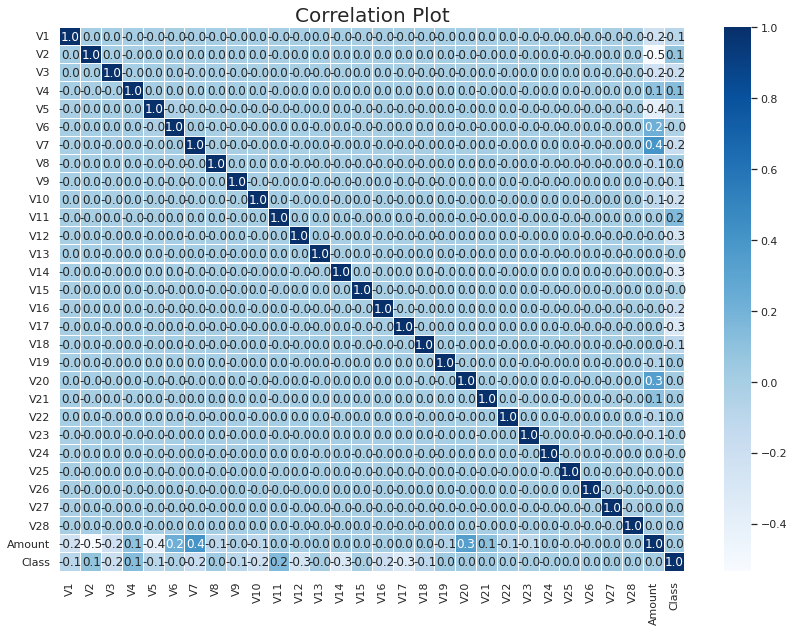

In [ ]:
plt.figure(figsize = (14,10))
plt.title('Correlation Plot', size = 20)
corr = data.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Blues",fmt='.1f',annot=True)
plt.show()

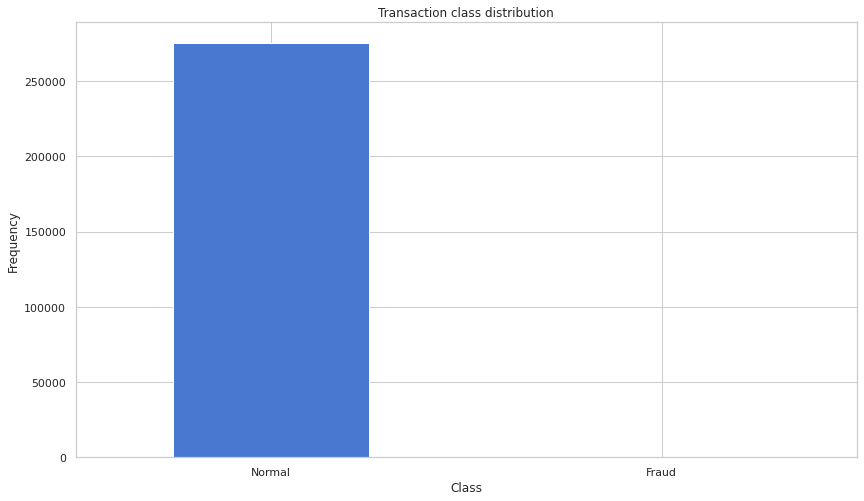

In [ ]:
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");


In [ ]:
Total_transactions = len(data)
normal = len(data[data.Class == 0])
fraudulent = len(data[data.Class == 1])
fraud_percentage = round(fraudulent/normal*100, 2)
print(cl('Total number of Transctions are {}'.format(Total_transactions), attrs = ['bold']))
print(cl('Number of Normal Transactions are {}'.format(normal), attrs = ['bold']))
print(cl('Number of fraudulent Transactions are {}'.format(fraudulent), attrs = ['bold']))
print(cl('Percentage of fraud Transactions is {}'.format(fraud_percentage), attrs = ['bold']))

Total number of Transctions are 284807
Number of Normal Transactions are 284315
Number of fraudulent Transactions are 492
Percentage of fraud Transactions is 0.17


In [ ]:
frauds = data[data.Class == 1]
normal = data[data.Class == 0]

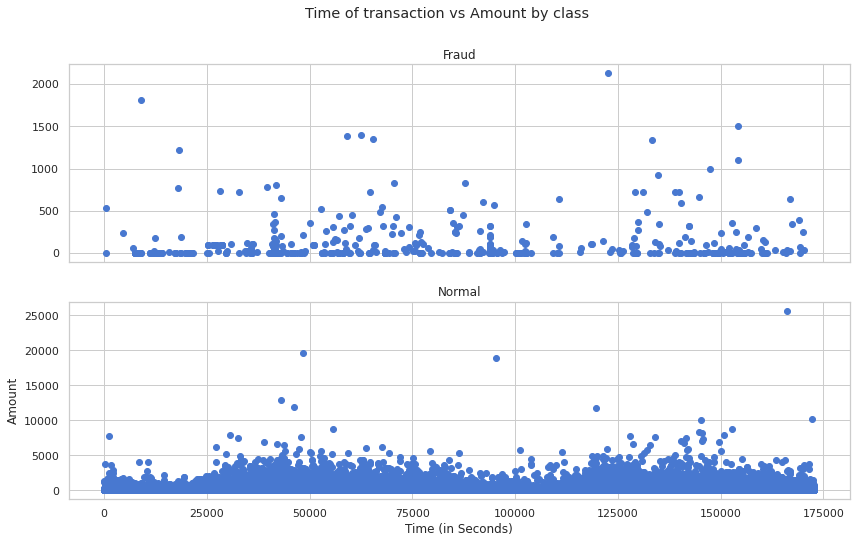

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [ ]:
data.drop(['Time'], axis=1, inplace=True)

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.shape

(275663, 30)

In [ ]:
sc = StandardScaler()
amount = data['Amount'].values
data['Amount'] = sc.fit_transform(amount.reshape(-1, 1))

# Splitting into test and training set

In [ ]:
X = data.drop('Class', axis = 1).values
y = data['Class'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=1)

# Applying oversampling with SMOTE

In [ ]:
smote = SMOTE(random_state=1)

X_train_os, y_train_os = smote.fit_resample(X_train, y_train)


In [ ]:
X_train_os, X_val_os, y_train_os, y_val_os = train_test_split(X_train_os, y_train_os, stratify=y_train_os, test_size=0.2, random_state = 1)

# Model Building and prediction (oversampling)


In [ ]:
model = keras.Sequential([
    layers.Dense(60, activation='relu', input_shape=(X_train.shape[-1],)),
    layers.Dropout(0.5),
    layers.Dense(30, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['Recall'])

EPOCHS = 200
BATCH_SIZE = 1000 #We need to include a batch size now since there are lots of data in the training set

early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val_os, y_val_os),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=0
)

In [ ]:
y_pred_prob_os = model.predict(X_test)
y_pred_os = y_pred_prob_os.round()

In [ ]:
print(classification_report(y_test, y_pred_os.round(), target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       1.00      1.00      1.00     55038
         Yes       0.88      0.76      0.81        95

    accuracy                           1.00     55133
   macro avg       0.94      0.88      0.91     55133
weighted avg       1.00      1.00      1.00     55133



# Applying undersampling

In [ ]:
rus = RandomUnderSampler(random_state=1)

In [ ]:
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

In [ ]:
X_train_us, X_val_us, y_train_us, y_val_us = train_test_split(X_train_us, y_train_us, test_size=0.2, random_state = 1)

# Model building and prediction (undersampling)

In [ ]:
model = keras.Sequential([
    layers.Dense(50, activation='relu', input_shape=(X_train.shape[-1],)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['Recall']) #choose recall as the metric


EPOCHS = 200

#setup earlystopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train_us, y_train_us,
    validation_data=(X_val_us, y_val_us),
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=0
)

In [ ]:
y_pred_prob_us = model.predict(X_test)
y_pred_us = y_pred_prob_us.round()

In [ ]:
print(classification_report(y_test, y_pred_us, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       1.00      0.96      0.98     55038
         Yes       0.04      0.92      0.08        95

    accuracy                           0.96     55133
   macro avg       0.52      0.94      0.53     55133
weighted avg       1.00      0.96      0.98     55133



In [81]:
conf_matrix_os = confusion_matrix(y_true=y_test, y_pred=y_pred_os)
conf_matrix_us = confusion_matrix(y_true=y_test, y_pred=y_pred_os)

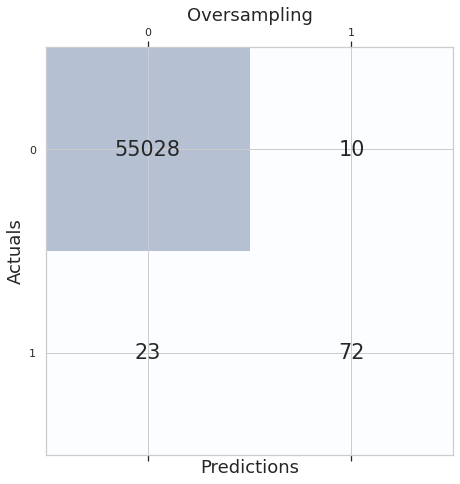

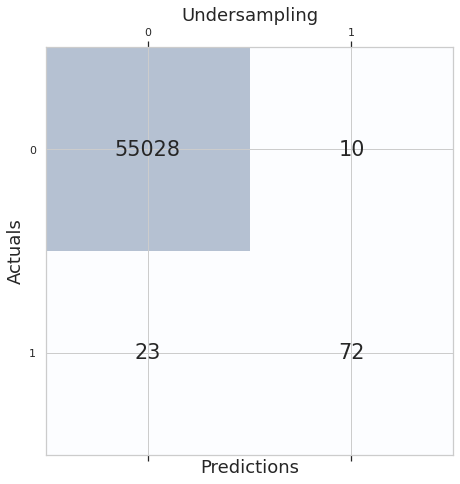

In [83]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix_os, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix_os.shape[0]):
    for j in range(conf_matrix_os.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_os[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Oversampling', fontsize=18)
plt.show()

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix_us, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix_us.shape[0]):
    for j in range(conf_matrix_us.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_us[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Undersampling', fontsize=18)
plt.show()
